# MyMDB Analyzer
This notebook accesses the IMDb-Scraping pipeline consisting of the webscraper, the database connector and provides a GUI for the interactive visualization.

![IMDb Logo](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/IMDB_Logo_2016.svg/440px-IMDB_Logo_2016.svg.png)

[Wikipedia IMDb Definition](https://en.wikipedia.org/wiki/IMDb):

IMDb (an acronym for `I`nternet `M`ovie `D`ata`b`ase) is an online database of information related to films, television series, podcasts, home videos, video games, and streaming content online – including cast, production crew and personal biographies [...]

This notebook visually explores rankings of movies and actors and 

## USAGE
Step through this notebook manually so everything is executed in order

#### OVERCOMING TECHNICAL DIFFICULTIES

In [1]:
# workarround for using event_loops in notebooks (ipykernel already uses the global non-reentrant one)
import nest_asyncio
nest_asyncio.apply()

#### Imports

In [2]:
import db
import analyze
import ui

connecting to db via conn_str: DRIVER=SQL Server;SERVER=localhost;PORT=1433;DATABASE=MyMDB;UID=SA;PWD=Pr0dRdyPw!


### SCRAPING
Challenges were respecting the site's scraping rules located in robots.txt, not getting timed out even though we followed through and handling those timeouts as well as handling (rather omitting a ton of) missing/format-inhomogenous data as well as asynchronous caching in python.

In [3]:
movies = []
import_ui = ui.init_ui(movies)
import_ui

100 movies acquired

In [5]:
movies = import_ui.movies
# try:
#     movies = import_ui.movies
# except AttributeError:
#     input("press enter to continue")
#     movies = import_ui.movies

### INSERTION
This part was done purely in the SQL Server Backend, using a stored procedure for parsing the insertion data, and taking care of NaN values and the likes.

A trigger was used to recursively update the average instead of recomputation over several tables for each new insert.

In [6]:
for movie in movies:
    try:
        db.insert_movie(**movie)
    except Exception as e:
        print(f"issue at {movie}\n{e}")
"no duplicates found" if db.check_no_duplicates() else "duplicates in actors detected"

'no duplicates found'

### READING
For further analysis the movies are queried back from the db and converted to dataframes

In [7]:
df_movies = analyze.get_movie_dataframe()
df_actors = analyze.get_actors_dataframe()
df_movie_actors = analyze.get_movie_actors_dataframe()
df_actor_features = analyze.get_actor_feature_dataframe()
df_movie_features = analyze.get_movie_feature_dataframe()
df_summary = (
 analyze.get_summary_dataframe()
 .sort_values(by="name")
)

display("movies", df_movies.head())
display("actors", df_actors.head())
display("movie_actors", df_movie_actors.head(5))
display("joined data", df_summary.head(10))
display(
    df_summary
    .drop(["movie_id", "actor_id"], axis=1)
    .describe()
)
display("interesting features for actor analysis", df_actor_features.head())
display(df_actor_features.describe())
display("interesting features for movie analysis", df_movie_features.head())
display(df_movie_features.describe())

year              int64
budget          float64
gross_income    float64
rating          float64
dtype: object


'movies'

,id,title,year,genre,rating,budget,gross_income
0,475,Krieg der Sterne,1977,Action,8.5,11000000.0000,775398007.0000
1,476,Einer flog über das Kuckucksnest,1975,Drama,8.6,3000000.0000,109114817.0000
2,481,Reservoir Dogs: Wilde Hunde,1992,Krimi,8.3,1200000.0000,2913644.0000
3,482,Shining,1980,Drama,8.4,19000000.0000,47351766.0000
4,484,Fight Club,1999,Drama,8.7,63000000.0000,101209702.0000


'actors'

,id,name,age,avg_rating
0,2503,Jack Purvis,86,8.6
1,2504,Peter Cushing,110,8.5
2,2505,David Prowse,88,8.5
3,2506,Anthony Daniels,77,8.5
4,2507,Peter Mayhew,79,8.6


'movie_actors'

,movie_id,actor_id
0,475,2503
1,475,2504
2,475,2505
3,475,2506
4,475,2507


'joined data'

,name,age,avg_rating,movie_id,actor_id,title,year,genre,rating,budget,gross_income
47,Aaron Eckhart,55,9.0,488,2598,The Dark Knight,2008,Action,9.0,185000000.0000,1006234167.0000
271,Abdo Abdo,-1,8.3,548,2946,Capernaum: Stadt der Hoffnung,2018,Drama,8.3,4000000.0000,64417003.0000
213,Abe Vigoda,102,9.2,537,2886,Der Pate,1972,Krimi,9.2,6000000.0000,250341816.0000
150,Adi Nitzan,-1,8.9,522,2801,Schindlers Liste,1993,Biografie,8.9,22000000.0000,322161245.0000
308,Adolphe Menjou,133,8.4,564,3029,Wege zum Ruhm,1957,Drama,8.4,935000.0000,5252.0000
216,Al Pacino,83,9.2,537,2889,Der Pate,1972,Krimi,9.2,6000000.0000,250341816.0000
74,Aldo Berti,87,8.4,496,2653,Spiel mir das Lied vom Tod,1968,Western,8.4,5000000.0000,5435024.0000
9,Alec Guinness,109,8.5,519,2634,Das Imperium schlägt zurück,1980,Action,8.7,18000000.0000,538375067.0000
55,Alec Guinness,109,8.5,493,2634,Die Rückkehr der Jedi-Ritter,1983,Action,8.3,32500000.0000,475106177.0000
66,Alexandra Rapaport,51,8.3,495,2645,Die Jagd,2012,Drama,8.3,20000000.0000,15886373.0000


,age,avg_rating,year
count,314.000000,314.000000,314.000000
mean,57.525478,8.512102,1989.942675
std,42.753708,0.216817,22.050405
min,-1.000000,8.200000,1931.000000
25%,-1.000000,8.300000,1977.000000
50%,61.500000,8.500000,1996.000000
75%,89.000000,8.600000,2006.000000
max,152.000000,9.200000,2023.000000


'interesting features for actor analysis'

,name,age,appearances,avg_rating
0,Sterling Hayden,107,1,9.2
1,Richard S. Castellano,89,1,9.2
2,John Marley,115,1,9.2
3,Al Pacino,83,1,9.2
4,Abe Vigoda,102,1,9.2


,age,appearances,avg_rating
count,226.000000,226.000000,226.000000
mean,77.991150,1.026549,8.523894
std,28.956364,0.161117,0.231430
min,21.000000,1.000000,8.200000
25%,55.000000,1.000000,8.400000
50%,70.000000,1.000000,8.500000
75%,97.500000,1.000000,8.600000
max,152.000000,2.000000,9.200000


'interesting features for movie analysis'

,year,budget,gross_income,rating
0,1977,11000000.0,775398007.0,8.5
1,1975,3000000.0,109114817.0,8.6
2,1992,1200000.0,2913644.0,8.3
3,1980,19000000.0,47351766.0,8.4
4,1999,63000000.0,101209702.0,8.7


,year,budget,gross_income,rating
count,56.000000,5.600000e+01,5.300000e+01,56.000000
mean,1989.839286,1.072472e+08,3.548595e+08,8.510714
std,22.529800,3.301259e+08,5.151849e+08,0.221301
min,1931.000000,1.522200e+04,5.252000e+03,8.200000
25%,1976.500000,3.225000e+06,3.205292e+07,8.300000
50%,1996.000000,1.950000e+07,2.139288e+08,8.500000
75%,2006.000000,9.325000e+07,4.751062e+08,8.600000
max,2023.000000,2.400000e+09,2.799439e+09,9.200000


### Visualization


c:\Users\NiJoL\anaconda3\envs\MyMDB\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


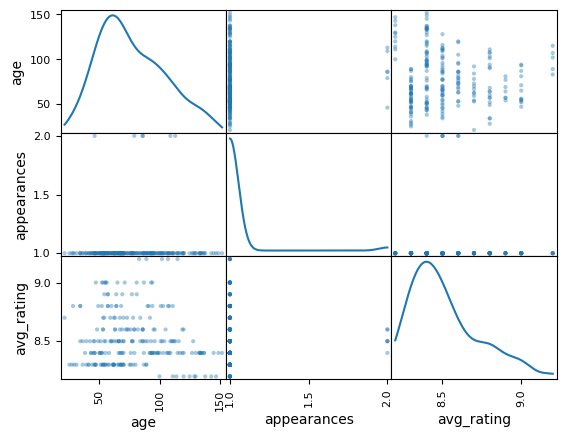

In [8]:
analyze.scattermatrix_actors(
    df_actor_features.drop(df_actor_features[df_actor_features["age"] == -1].index)
)

# outlook

- scrape random movies and try to classify if a given actor could really make it using the top 250 (interesting outliers for certain actors included in top 250 that say only did a single movie)
- try to predict imdb rating